# 9.5 Finetuning: dostrajanie modelu do nowych zadań

W tym skrypcie znajdziemy wyniki eksperymentów opisanych w rozdziale 9.5 ,,Finetuning: dostrajanie modelu do nowych zadań''.


### Importowanie niezbędnych modułow

In [1]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm


print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)

PyTorch: 1.10.0
Torchvision: 0.11.1


Klasa ,,*AverageMeter*'' przechowuje oraz przetwarza częściowe wyniki zapisywane w poszczegółnych etapach uczenia modelu. Funkcja ,,*accuracy*'' liczy dokładność sieci w procesie uczenia lub jej walidacji.

In [2]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum = self.sum + val * n
        self.count = self.count + n
        self.avg = self.sum / self.count


def accuracy(output, target):
    pred = (output > 0).float()
    correct = torch.sum(pred.eq(target))

    return correct * (100.0 / target.shape[0])

W tej części przygotowujemy zbiór danych do trenowania i walidacji modelu. Przetwarzamy obrazki ze zbioru *hymenoptera_data* do tensorów, które są pobierane iteracyjnie w batchach podczas trenowania sieci (zmienne: ,,*train_loader*'', ,,*test_loader*'').

In [3]:
root = "/datasets/hymenoptera_data"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

transform_train = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(f"{root}/train/", transform_train),
    batch_size=10,
    shuffle=True,
    num_workers=4,
    pin_memory=False,
)


transform_test = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(f"{root}/val/", transform_test),
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=False,
)

device=device(type='cuda')


# Finetuning

W poniższym kodzie importujemy pretrenowany model *ResNet18*. Podmieniamy w nim warstwę fully-connected na własną ponieważ model ten uczony był na zbiorze *ImageNet*, który ma 1000 klas (wyjściem sieci jest wektor ze zbioru $\mathbb{R}^{1000}$) zaś nasz model powinien zwracać skalar ($\mathbb{R}$).

In [4]:
model = models.resnet18(pretrained=True)

# freezing parameters
for param in model.parameters():
    param.requires_grad = False

input_size = model.fc.in_features
model.fc = torch.nn.Linear(input_size, 1)

# print(model)

model = model.to(device)

Uczenie modelu i jego walidacja.

In [ ]:
params = model.parameters()
print("Params to train:")
params = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)
        print(name)

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

scores = {"train": {"loss": [], "Prec@1": []}, "test": {"loss": [], "Prec@1": []}}

print("The results are described by: (loss, acc)")
epochs = 20
for epoch in range(epochs):

    # training
    model.train()

    losses = AverageMeter()
    acc = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, target in train_tqdm:
        image, target = image.to(device), target.float().to(device)

        output = model(image).view(-1)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        prec = accuracy(output, target)
        losses.update(loss.item(), image.shape[0])
        acc.update(prec.item(), image.shape[0])

        train_tqdm.set_description(
            f"TRAIN [loss, acc]: "
            f"[{losses.val:.4f} ({losses.avg:.4f}),{acc.val:2.2f} ({acc.avg:2.2f})]"
        )

    scheduler.step()

    scores["train"]["loss"].append(losses.avg)
    scores["train"]["Prec@1"].append(acc.avg)

    # validating
    model.eval()

    losses = AverageMeter()
    acc = AverageMeter()

    with torch.no_grad():
        eval_tqdm = tqdm(test_loader, total=len(test_loader), leave=False)
        for image, target in eval_tqdm:
            image, target = image.to(device), target.float().to(device)

            output = model(image).view(-1)
            loss = criterion(output, target)

            prec = accuracy(output, target)
            losses.update(loss.item(), image.shape[0])
            acc.update(prec.item(), image.shape[0])

            eval_tqdm.set_description(
                f"TEST [loss, acc]: "
                f"[{losses.val:.4f} ({losses.avg:.4f}),{acc.val:2.2f} ({acc.avg:2.2f})]"
            )

    scores["test"]["loss"].append(losses.avg)
    scores["test"]["Prec@1"].append(acc.avg)

    print(
        f"Epoch: [{epoch + 1}/{epochs}]\t"
        f"train: ({scores['train']['loss'][-1]:.4f},{scores['train']['Prec@1'][-1]:2.2f})\t"
        f"test: ({scores['test']['loss'][-1]:.4f},{scores['test']['Prec@1'][-1]:2.2f})\t"
        f"lr: {scheduler.get_last_lr()[0]:.4g}"
    )

Zapisujemy poszczególne wyniki trenowania modelu do słownika w celu porównania ich z wynikami sieci neuronowej bez finetuningu.

In [6]:
total_scores = {'with_finetuning': scores}

# Bez finetuningu, uczenie od nowa

Poniżej tworzymy model w oparciu o architekturę *ResNet18*.

In [7]:
model = models.resnet18(pretrained=False)
input_size = model.fc.in_features
model.fc = torch.nn.Linear(input_size, 1)

# print(model)

model = model.to(device)

Uczenie modelu i jego walidacja.

In [ ]:
params = model.parameters()
print("Params to learn:")
params = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)
        print(name)

optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

scores = {"train": {"loss": [], "Prec@1": []}, "test": {"loss": [], "Prec@1": []}}

print("The results are described by: (loss, acc)")
epochs = 50
for epoch in range(epochs):

    # training
    model.train()

    losses = AverageMeter()
    acc = AverageMeter()

    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
    for image, target in train_tqdm:
        image, target = image.to(device), target.float().to(device)

        output = model(image).view(-1)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        prec = accuracy(output, target)
        losses.update(loss.item(), image.shape[0])
        acc.update(prec.item(), image.shape[0])

        train_tqdm.set_description(
            f"TRAIN [loss, acc]: "
            f"[{losses.val:.4f} ({losses.avg:.4f}),{acc.val:2.2f} ({acc.avg:2.2f})]"
        )

    scheduler.step()

    scores["train"]["loss"].append(losses.avg)
    scores["train"]["Prec@1"].append(acc.avg)

    # validating
    model.eval()

    losses = AverageMeter()
    acc = AverageMeter()

    with torch.no_grad():
        eval_tqdm = tqdm(test_loader, total=len(test_loader), leave=False)
        for image, target in eval_tqdm:
            image, target = image.to(device), target.float().to(device)

            output = model(image).view(-1)
            loss = criterion(output, target)

            prec = accuracy(output, target)
            losses.update(loss.item(), image.shape[0])
            acc.update(prec.item(), image.shape[0])

            eval_tqdm.set_description(
                f"TEST [loss, acc]: "
                f"[{losses.val:.4f} ({losses.avg:.4f}),{acc.val:2.2f} ({acc.avg:2.2f})]"
            )

    scores["test"]["loss"].append(losses.avg)
    scores["test"]["Prec@1"].append(acc.avg)

    print(
        f"Epoch: [{epoch + 1}/{epochs}]\t"
        f"train: ({scores['train']['loss'][-1]:.4f},{scores['train']['Prec@1'][-1]:2.2f})\t"
        f"test: ({scores['test']['loss'][-1]:.4f},{scores['test']['Prec@1'][-1]:2.2f})\t"
        f"lr: {scheduler.get_last_lr()[0]:.4g}"
    )

Poniżej przedstawiamy wyniki powyższych dwóch modeli w postaci wykresów. Na pierwszym pokazujemy dokładność modeli w poszczególnych etapach ich uczenia, zaś na drugim wykresie przedstawiamy jak zmienia się funkcja kosztu w czasie ich uczenia.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2.5)
sns.set_style("whitegrid")

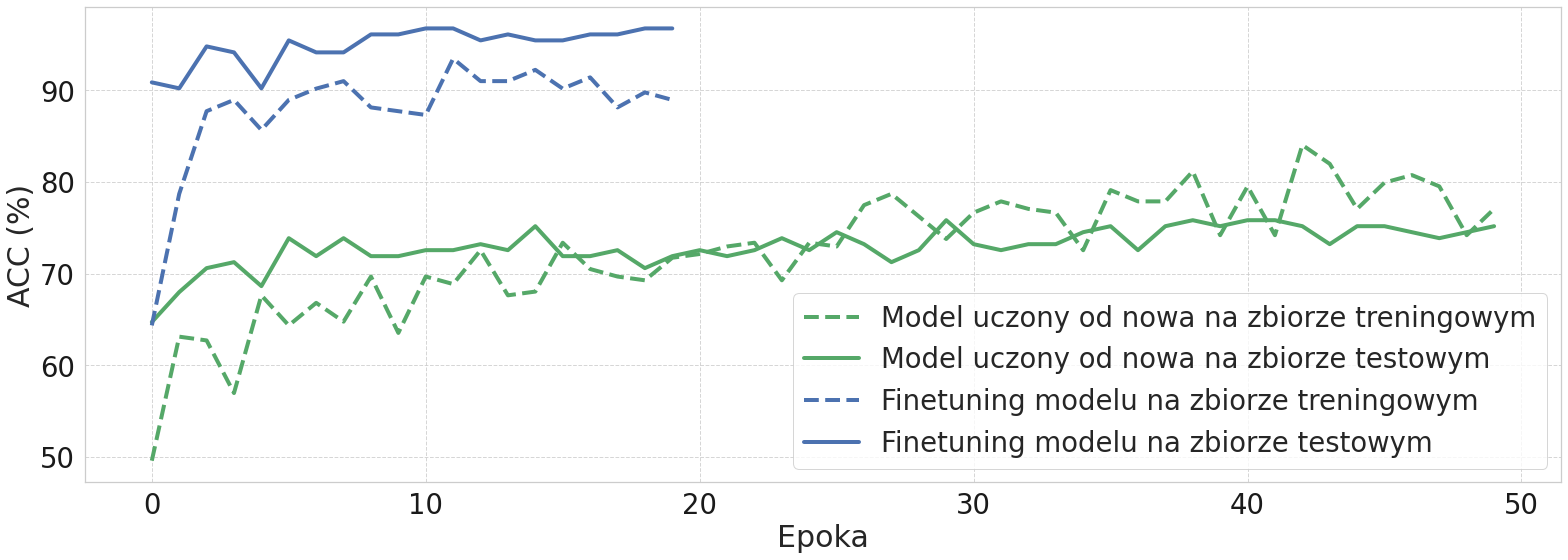

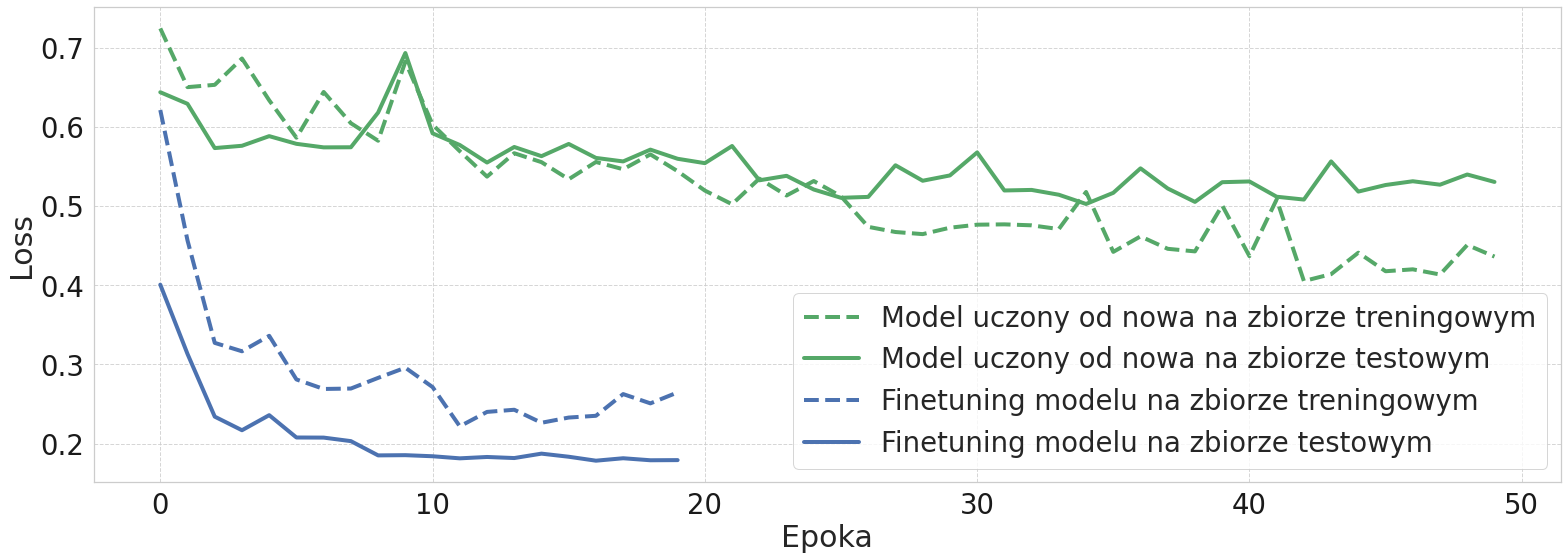

In [11]:
# Prec@1
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    total_scores["without_finetuning"]["train"]["Prec@1"],
    "g--",
    linewidth=4,
    markersize=12,
    label="Model uczony od nowa na zbiorze treningowym",
)
ax.plot(
    total_scores["without_finetuning"]["test"]["Prec@1"],
    "g-",
    linewidth=4,
    markersize=12,
    label="Model uczony od nowa na zbiorze testowym",
)
ax.plot(
    total_scores["with_finetuning"]["train"]["Prec@1"],
    "b--",
    linewidth=4,
    markersize=12,
    label="Finetuning modelu na zbiorze treningowym",
)
ax.plot(
    total_scores["with_finetuning"]["test"]["Prec@1"],
    "b-",
    linewidth=4,
    markersize=12,
    label="Finetuning modelu na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)  # , labelsize=20)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("ACC (%)")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

plt.show()
plt.close()


# loss
fig = plt.figure(figsize=(22, 8))
ax = fig.add_subplot(111)
ax.plot(
    total_scores["without_finetuning"]["train"]["loss"],
    "g--",
    linewidth=4,
    markersize=12,
    label="Model uczony od nowa na zbiorze treningowym",
)
ax.plot(
    total_scores["without_finetuning"]["test"]["loss"],
    "g-",
    linewidth=4,
    markersize=12,
    label="Model uczony od nowa na zbiorze testowym",
)
ax.plot(
    total_scores["with_finetuning"]["train"]["loss"],
    "b--",
    linewidth=4,
    markersize=12,
    label="Finetuning modelu na zbiorze treningowym",
)
ax.plot(
    total_scores["with_finetuning"]["test"]["loss"],
    "b-",
    linewidth=4,
    markersize=12,
    label="Finetuning modelu na zbiorze testowym",
)
ax.tick_params(
    axis="both",
    which="both",
    direction="out",
    length=6,
    width=2,
    colors="k",
    grid_alpha=0.5,
)
ax.grid(which="both")
ax.grid(which="major", color="#CCCCCC", linestyle="--", alpha=0.8)
ax.grid(which="minor", color="#CCCCCC", linestyle=":", alpha=0.8)

ax.legend(loc=0)
ax.set_ylabel("Loss")
ax.set_xlabel("Epoka")
plt.tight_layout(pad=0.5)

plt.show()
plt.close()